In [1]:
import sys
sys.path.append('..')

from src.vector_store import load_vector_store, test_retrieval
from src.config import RETRIEVAL_K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Setup complete!")

✅ Setup complete!


In [2]:
print("Loading vector store...")
vectorstore = load_vector_store()
print(f"✅ Loaded {vectorstore.index.ntotal} embeddings")

2026-02-15 10:35:03,997 - src.vector_store - INFO - Loading FAISS index from d:\Personal Trainer Assistant\notebooks\..\faiss_index


Loading vector store...


d:\Personal Trainer Assistant\notebooks\..\src\vector_store.py:75: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
2026-02-15 10:35:05,132 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
d:\Personal Trainer Assistant\venv\Lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2026-02-15 10:35:07,821 - faiss.loader - INFO - Loading faiss w

✅ Loaded 4699 embeddings


In [3]:
test_queries = [
    {
        "query": "What do you recommend for protein intake?",
        "expected_topics": ["protein", "macronutrition", "nutrition"],
        "category": "nutrition"
    },
    {
        "query": "How should I structure my training split?",
        "expected_topics": ["how to structure", "program customization", "training"],
        "category": "training"
    },
    {
        "query": "Best exercises for chest development?",
        "expected_topics": ["exercise selection", "exercise library", "training"],
        "category": "training"
    },
    {
        "query": "Should I do cardio while bulking?",
        "expected_topics": ["cardio", "periodization", "energy"],
        "category": "nutrition"
    },
    {
        "query": "How to prevent training injuries?",
        "expected_topics": ["injury management", "warming up"],
        "category": "training"
    },
    {
        "query": "What supplements are worth taking?",
        "expected_topics": ["supplements", "nutrition"],
        "category": "nutrition"
    },
    {
        "query": "Explain muscle protein synthesis",
        "expected_topics": ["protein", "understanding muscle growth", "biochemistry"],
        "category": "science"
    },
    {
        "query": "How much sleep do I need for recovery?",
        "expected_topics": ["lifestyle factors", "recovery"],
        "category": "lifestyle"
    },
    {
        "query": "What's the difference between powerlifting and bodybuilding training?",
        "expected_topics": ["powerlifting", "program customization", "training"],
        "category": "training"
    },
    {
        "query": "How to calculate my calorie needs?",
        "expected_topics": ["energy", "macronutrition", "nutrition case"],
        "category": "nutrition"
    }
]

print(f"\nTest Queries: {len(test_queries)}")
for i, q in enumerate(test_queries, 1):
    print(f"  {i}. {q['query'][:60]}... ({q['category']})")


Test Queries: 10
  1. What do you recommend for protein intake?... (nutrition)
  2. How should I structure my training split?... (training)
  3. Best exercises for chest development?... (training)
  4. Should I do cardio while bulking?... (nutrition)
  5. How to prevent training injuries?... (training)
  6. What supplements are worth taking?... (nutrition)
  7. Explain muscle protein synthesis... (science)
  8. How much sleep do I need for recovery?... (lifestyle)
  9. What's the difference between powerlifting and bodybuilding ... (training)
  10. How to calculate my calorie needs?... (nutrition)


In [4]:
def calculate_precision_at_k(retrieved_topics, expected_topics, k):
    """Precision@K: How many retrieved are relevant"""
    retrieved_k = retrieved_topics[:k]
    relevant = sum(1 for topic in retrieved_k if any(exp in topic.lower() for exp in expected_topics))
    return relevant / k if k > 0 else 0

def calculate_recall_at_k(retrieved_topics, expected_topics, k):
    """Recall@K: How many relevant were retrieved"""
    retrieved_k = retrieved_topics[:k]
    relevant_retrieved = sum(1 for topic in retrieved_k if any(exp in topic.lower() for exp in expected_topics))
    return relevant_retrieved / len(expected_topics) if expected_topics else 0

def calculate_mrr(retrieved_topics, expected_topics):
    """Mean Reciprocal Rank: Position of first relevant result"""
    for i, topic in enumerate(retrieved_topics, 1):
        if any(exp in topic.lower() for exp in expected_topics):
            return 1 / i
    return 0

def calculate_ndcg_at_k(retrieved_topics, expected_topics, k):
    """Normalized Discounted Cumulative Gain"""
    dcg = 0
    for i, topic in enumerate(retrieved_topics[:k], 1):
        relevance = 1 if any(exp in topic.lower() for exp in expected_topics) else 0
        dcg += relevance / np.log2(i + 1)
    
    # Ideal DCG (all relevant docs first)
    ideal_relevance = [1] * min(len(expected_topics), k)
    idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
    
    return dcg / idcg if idcg > 0 else 0

print("✅ Metrics functions defined")


✅ Metrics functions defined


In [5]:
print("\nRunning retrieval evaluation...")

results = []

for test_case in tqdm(test_queries, desc="Evaluating"):
    query = test_case["query"]
    expected_topics = test_case["expected_topics"]
    
    # Retrieve documents
    start_time = time.time()
    docs = vectorstore.similarity_search_with_score(query, k=RETRIEVAL_K)
    latency = time.time() - start_time
    
    # Extract topics
    retrieved_topics = [doc.metadata.get('topic', 'unknown').lower() for doc, _ in docs]
    retrieved_categories = [doc.metadata.get('category', 'unknown') for doc, _ in docs]
    
    # Calculate metrics
    precision_k = calculate_precision_at_k(retrieved_topics, expected_topics, RETRIEVAL_K)
    recall_k = calculate_recall_at_k(retrieved_topics, expected_topics, RETRIEVAL_K)
    mrr = calculate_mrr(retrieved_topics, expected_topics)
    ndcg_k = calculate_ndcg_at_k(retrieved_topics, expected_topics, RETRIEVAL_K)
    
    # Category accuracy (did we retrieve from correct category?)
    category_match = sum(1 for cat in retrieved_categories if cat == test_case["category"])
    category_accuracy = category_match / len(retrieved_categories)
    
    results.append({
        "query": query,
        "expected_category": test_case["category"],
        "precision@k": precision_k,
        "recall@k": recall_k,
        "mrr": mrr,
        "ndcg@k": ndcg_k,
        "category_accuracy": category_accuracy,
        "latency_ms": latency * 1000,
        "retrieved_topics": ", ".join(retrieved_topics[:3])
    })

df_results = pd.DataFrame(results)

print("\n✅ Evaluation complete!")


Running retrieval evaluation...


Evaluating: 100%|██████████| 10/10 [00:00<00:00, 13.92it/s]


✅ Evaluation complete!


In [6]:
print("\n" + "="*80)
print("📊 RETRIEVAL EVALUATION RESULTS")
print("="*80)

summary = {
    "Mean Precision@K": df_results["precision@k"].mean(),
    "Mean Recall@K": df_results["recall@k"].mean(),
    "Mean MRR": df_results["mrr"].mean(),
    "Mean NDCG@K": df_results["ndcg@k"].mean(),
    "Mean Category Accuracy": df_results["category_accuracy"].mean(),
    "Mean Latency (ms)": df_results["latency_ms"].mean(),
}

for metric, value in summary.items():
    print(f"  {metric}: {value:.3f}")

print("\n" + "="*80)


📊 RETRIEVAL EVALUATION RESULTS
  Mean Precision@K: 0.883
  Mean Recall@K: 2.000
  Mean MRR: 0.950
  Mean NDCG@K: 1.496
  Mean Category Accuracy: 0.850
  Mean Latency (ms): 71.382



In [7]:
print("\n📋 DETAILED RESULTS:")
print(df_results[['query', 'precision@k', 'recall@k', 'mrr', 'ndcg@k', 'category_accuracy']].to_string(index=False))


📋 DETAILED RESULTS:
                                                                query  precision@k  recall@k  mrr   ndcg@k  category_accuracy
                            What do you recommend for protein intake?     0.833333  1.666667  1.0 1.348702           1.000000
                            How should I structure my training split?     1.000000  2.000000  1.0 1.550810           1.000000
                                Best exercises for chest development?     1.000000  2.000000  1.0 1.550810           1.000000
                                    Should I do cardio while bulking?     0.833333  1.666667  1.0 1.383649           0.833333
                                    How to prevent training injuries?     0.500000  1.500000  1.0 1.156919           0.833333
                                   What supplements are worth taking?     1.000000  3.000000  1.0 2.026247           1.000000
                                     Explain muscle protein synthesis     1.000000  2.000000  1.0

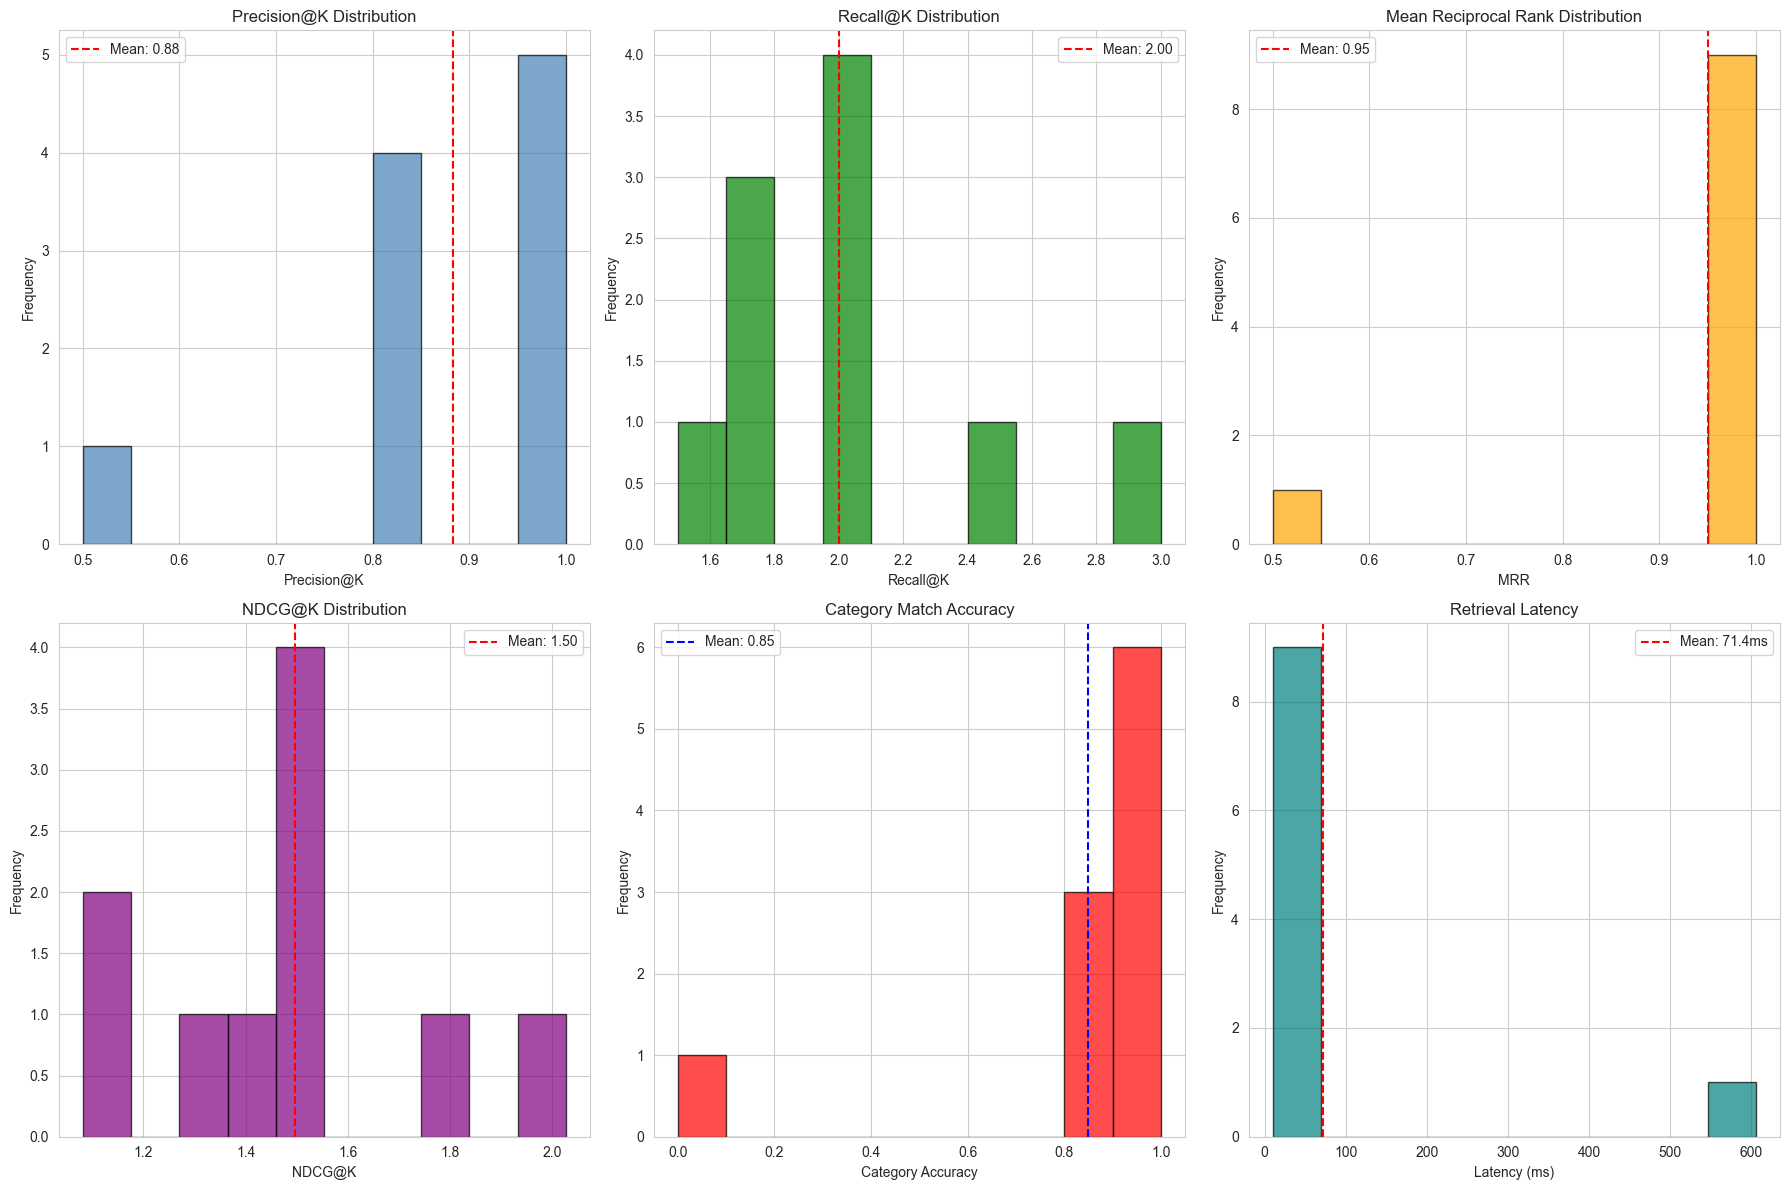

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Precision@K distribution
axes[0, 0].hist(df_results['precision@k'], bins=10, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(df_results['precision@k'].mean(), color='red', linestyle='--', label=f'Mean: {df_results["precision@k"].mean():.2f}')
axes[0, 0].set_xlabel('Precision@K')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Precision@K Distribution')
axes[0, 0].legend()

# 2. Recall@K distribution
axes[0, 1].hist(df_results['recall@k'], bins=10, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].axvline(df_results['recall@k'].mean(), color='red', linestyle='--', label=f'Mean: {df_results["recall@k"].mean():.2f}')
axes[0, 1].set_xlabel('Recall@K')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Recall@K Distribution')
axes[0, 1].legend()

# 3. MRR distribution
axes[0, 2].hist(df_results['mrr'], bins=10, edgecolor='black', alpha=0.7, color='orange')
axes[0, 2].axvline(df_results['mrr'].mean(), color='red', linestyle='--', label=f'Mean: {df_results["mrr"].mean():.2f}')
axes[0, 2].set_xlabel('MRR')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Mean Reciprocal Rank Distribution')
axes[0, 2].legend()

# 4. NDCG@K distribution
axes[1, 0].hist(df_results['ndcg@k'], bins=10, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].axvline(df_results['ndcg@k'].mean(), color='red', linestyle='--', label=f'Mean: {df_results["ndcg@k"].mean():.2f}')
axes[1, 0].set_xlabel('NDCG@K')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('NDCG@K Distribution')
axes[1, 0].legend()

# 5. Category Accuracy
axes[1, 1].hist(df_results['category_accuracy'], bins=10, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].axvline(df_results['category_accuracy'].mean(), color='blue', linestyle='--', label=f'Mean: {df_results["category_accuracy"].mean():.2f}')
axes[1, 1].set_xlabel('Category Accuracy')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Category Match Accuracy')
axes[1, 1].legend()

# 6. Latency distribution
axes[1, 2].hist(df_results['latency_ms'], bins=10, edgecolor='black', alpha=0.7, color='teal')
axes[1, 2].axvline(df_results['latency_ms'].mean(), color='red', linestyle='--', label=f'Mean: {df_results["latency_ms"].mean():.1f}ms')
axes[1, 2].set_xlabel('Latency (ms)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Retrieval Latency')
axes[1, 2].legend()

plt.tight_layout()
plt.show()


📊 METRICS BY CATEGORY:
                   precision@k  recall@k    mrr  ndcg@k  category_accuracy
expected_category                                                         
lifestyle                0.833     2.500  1.000   1.762              0.833
nutrition                0.917     2.083  1.000   1.577              0.958
science                  1.000     2.000  1.000   1.551              0.000
training                 0.833     1.792  0.875   1.335              0.958


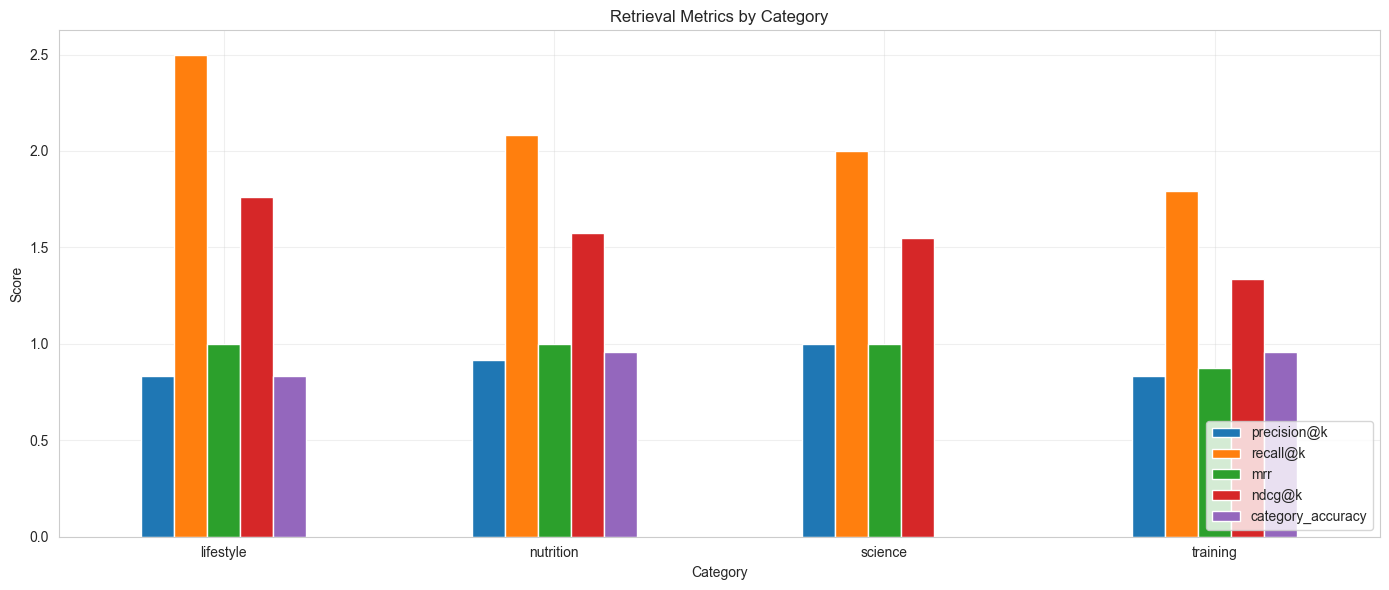

In [9]:
category_metrics = df_results.groupby('expected_category').agg({
    'precision@k': 'mean',
    'recall@k': 'mean',
    'mrr': 'mean',
    'ndcg@k': 'mean',
    'category_accuracy': 'mean'
}).round(3)

print("\n📊 METRICS BY CATEGORY:")
print(category_metrics)

# Visualize
category_metrics.plot(kind='bar', figsize=(14, 6), rot=0)
plt.title('Retrieval Metrics by Category')
plt.ylabel('Score')
plt.xlabel('Category')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()